In [1]:
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt


from SimCLR_data import *

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
train_path = "data/MICCAI_long_tail_train.tfrecords"
train_index = "data/MICCAI_long_tail_train.tfindex"
batch_size = 128

In [4]:
train_dl = SIMCLR_loader(train_path, train_index, batch_size, 0, True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 2, 3, 256, 256])


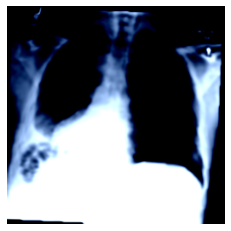

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


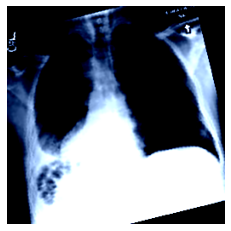

In [5]:
idxx = 6
for example in train_dl:
    print(example.shape)
    image_numpy = example[idxx][0].squeeze().permute(1, 2, 0).cpu().numpy()
    plt.imshow(image_numpy)
    plt.axis('off')
    plt.show()
    
    image_numpy = example[idxx][1].squeeze().permute(1, 2, 0).cpu().numpy()
    plt.imshow(image_numpy)
    plt.axis('off')
    plt.show()
    break

In [6]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class SimCLR(nn.Module):
    def __init__(self, linear_eval=False):
        super().__init__()
        self.linear_eval = linear_eval
        resnet18 = models.resnet18(pretrained=False)
        resnet18.fc = Identity()
        self.encoder = resnet18
        self.projection = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 256)
        )
    def forward(self, x):
        if not self.linear_eval:
            x = torch.cat(x, dim=0)
        
        encoding = self.encoder(x)
        projection = self.projection(encoding) 
        return projection

In [7]:
LABELS = torch.cat([torch.arange(batch_size) for i in range(2)], dim=0)
LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
LABELS = LABELS.to(DEVICE) #128,128

def cont_loss(features, temp):
    similarity_matrix = torch.matmul(features, features.T) 

    mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)

    labels = LABELS[~mask].view(LABELS.shape[0], -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

    logits = logits / temp
    return logits, labels

In [8]:
simclr_model = SimCLR().to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(simclr_model.parameters(), lr = 0.000001, weight_decay=0.00001)

C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
print(LABELS.shape)

torch.Size([256, 256])


In [10]:
EPOCHS = 20
for epoch in range(EPOCHS):
    t0 = time.time()
    running_loss = 0.0
    for i, views in enumerate(train_dl):
        # tmp = [view.to(DEVICE) for view in views]
        #print(len(tmp))
        projections = simclr_model([view.to(DEVICE) for view in views])
#         if i % 10000 == 0:
#             print(projections)
        logits, labels = cont_loss(projections, temp=2)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print(f'EPOCH: {epoch+1} BATCH: {i+1} LOSS: {(running_loss/100):.4f} ')
            running_loss = 0.0
    print(f'Time taken: {((time.time()-t0)/60):.3f} mins')

EPOCH: 1 BATCH: 10 LOSS: 1.1069 
EPOCH: 1 BATCH: 20 LOSS: 1.0649 
EPOCH: 1 BATCH: 30 LOSS: 1.0835 
EPOCH: 1 BATCH: 40 LOSS: 0.8349 
EPOCH: 1 BATCH: 50 LOSS: 0.7142 
EPOCH: 1 BATCH: 60 LOSS: 0.7213 
EPOCH: 1 BATCH: 70 LOSS: 0.7118 
EPOCH: 1 BATCH: 80 LOSS: 0.6576 
EPOCH: 1 BATCH: 90 LOSS: 0.5960 
EPOCH: 1 BATCH: 100 LOSS: 0.6004 
EPOCH: 1 BATCH: 110 LOSS: 0.5678 
EPOCH: 1 BATCH: 120 LOSS: 0.5726 
EPOCH: 1 BATCH: 130 LOSS: 0.5754 
EPOCH: 1 BATCH: 140 LOSS: 0.5905 
EPOCH: 1 BATCH: 150 LOSS: 0.5736 
EPOCH: 1 BATCH: 160 LOSS: 0.5682 
EPOCH: 1 BATCH: 170 LOSS: 0.5646 
EPOCH: 1 BATCH: 180 LOSS: 0.5627 
EPOCH: 1 BATCH: 190 LOSS: 0.5628 
EPOCH: 1 BATCH: 200 LOSS: 0.5623 
EPOCH: 1 BATCH: 210 LOSS: 0.5587 
EPOCH: 1 BATCH: 220 LOSS: 0.5604 
EPOCH: 1 BATCH: 230 LOSS: 0.5601 
EPOCH: 1 BATCH: 240 LOSS: 0.5588 
EPOCH: 1 BATCH: 250 LOSS: 0.5578 
EPOCH: 1 BATCH: 260 LOSS: 0.5584 
EPOCH: 1 BATCH: 270 LOSS: 0.5608 
EPOCH: 1 BATCH: 280 LOSS: 0.5579 
EPOCH: 1 BATCH: 290 LOSS: 0.5591 
EPOCH: 1 BATCH: 300 LOS

EPOCH: 2 BATCH: 990 LOSS: 0.5544 
EPOCH: 2 BATCH: 1000 LOSS: 0.5546 
EPOCH: 2 BATCH: 1010 LOSS: 0.5545 
EPOCH: 2 BATCH: 1020 LOSS: 0.5546 
EPOCH: 2 BATCH: 1030 LOSS: 0.5544 
EPOCH: 2 BATCH: 1040 LOSS: 0.5545 
EPOCH: 2 BATCH: 1050 LOSS: 0.5546 
EPOCH: 2 BATCH: 1060 LOSS: 0.5545 
EPOCH: 2 BATCH: 1070 LOSS: 0.5546 
EPOCH: 2 BATCH: 1080 LOSS: 0.5545 
EPOCH: 2 BATCH: 1090 LOSS: 0.5545 
EPOCH: 2 BATCH: 1100 LOSS: 0.5546 
EPOCH: 2 BATCH: 1110 LOSS: 0.5546 
EPOCH: 2 BATCH: 1120 LOSS: 0.5545 
EPOCH: 2 BATCH: 1130 LOSS: 0.5545 
EPOCH: 2 BATCH: 1140 LOSS: 0.5545 
EPOCH: 2 BATCH: 1150 LOSS: 0.5545 
EPOCH: 2 BATCH: 1160 LOSS: 0.5544 
EPOCH: 2 BATCH: 1170 LOSS: 0.5545 
EPOCH: 2 BATCH: 1180 LOSS: 0.5545 
EPOCH: 2 BATCH: 1190 LOSS: 0.5546 
EPOCH: 2 BATCH: 1200 LOSS: 0.5546 
EPOCH: 2 BATCH: 1210 LOSS: 0.5546 
EPOCH: 2 BATCH: 1220 LOSS: 0.5544 
EPOCH: 2 BATCH: 1230 LOSS: 0.5545 
EPOCH: 2 BATCH: 1240 LOSS: 0.5545 
EPOCH: 2 BATCH: 1250 LOSS: 0.5546 
EPOCH: 2 BATCH: 1260 LOSS: 0.5546 
EPOCH: 2 BATCH: 1270 

EPOCH: 4 BATCH: 530 LOSS: 0.5543 
EPOCH: 4 BATCH: 540 LOSS: 0.5544 
EPOCH: 4 BATCH: 550 LOSS: 0.5543 
EPOCH: 4 BATCH: 560 LOSS: 0.5544 
EPOCH: 4 BATCH: 570 LOSS: 0.5543 
EPOCH: 4 BATCH: 580 LOSS: 0.5544 
EPOCH: 4 BATCH: 590 LOSS: 0.5543 
EPOCH: 4 BATCH: 600 LOSS: 0.5543 
EPOCH: 4 BATCH: 610 LOSS: 0.5544 
EPOCH: 4 BATCH: 620 LOSS: 0.5545 
EPOCH: 4 BATCH: 630 LOSS: 0.5543 
EPOCH: 4 BATCH: 640 LOSS: 0.5544 
EPOCH: 4 BATCH: 650 LOSS: 0.5543 
EPOCH: 4 BATCH: 660 LOSS: 0.5544 
EPOCH: 4 BATCH: 670 LOSS: 0.5543 
EPOCH: 4 BATCH: 680 LOSS: 0.5543 
EPOCH: 4 BATCH: 690 LOSS: 0.5543 
EPOCH: 4 BATCH: 700 LOSS: 0.5544 
EPOCH: 4 BATCH: 710 LOSS: 0.5544 
EPOCH: 4 BATCH: 720 LOSS: 0.5544 
EPOCH: 4 BATCH: 730 LOSS: 0.5543 
EPOCH: 4 BATCH: 740 LOSS: 0.5544 
EPOCH: 4 BATCH: 750 LOSS: 0.5544 
EPOCH: 4 BATCH: 760 LOSS: 0.5543 
EPOCH: 4 BATCH: 770 LOSS: 0.5543 
EPOCH: 4 BATCH: 780 LOSS: 0.5543 
EPOCH: 4 BATCH: 790 LOSS: 0.5544 
EPOCH: 4 BATCH: 800 LOSS: 0.5543 
EPOCH: 4 BATCH: 810 LOSS: 0.5544 
EPOCH: 4 BATCH

EPOCH: 6 BATCH: 70 LOSS: 0.5543 
EPOCH: 6 BATCH: 80 LOSS: 0.5542 
EPOCH: 6 BATCH: 90 LOSS: 0.5543 
EPOCH: 6 BATCH: 100 LOSS: 0.5542 
EPOCH: 6 BATCH: 110 LOSS: 0.5543 
EPOCH: 6 BATCH: 120 LOSS: 0.5543 
EPOCH: 6 BATCH: 130 LOSS: 0.5543 
EPOCH: 6 BATCH: 140 LOSS: 0.5543 
EPOCH: 6 BATCH: 150 LOSS: 0.5543 
EPOCH: 6 BATCH: 160 LOSS: 0.5543 
EPOCH: 6 BATCH: 170 LOSS: 0.5543 
EPOCH: 6 BATCH: 180 LOSS: 0.5543 
EPOCH: 6 BATCH: 190 LOSS: 0.5543 
EPOCH: 6 BATCH: 200 LOSS: 0.5542 
EPOCH: 6 BATCH: 210 LOSS: 0.5543 
EPOCH: 6 BATCH: 220 LOSS: 0.5542 
EPOCH: 6 BATCH: 230 LOSS: 0.5543 
EPOCH: 6 BATCH: 240 LOSS: 0.5543 
EPOCH: 6 BATCH: 250 LOSS: 0.5543 
EPOCH: 6 BATCH: 260 LOSS: 0.5543 
EPOCH: 6 BATCH: 270 LOSS: 0.5543 
EPOCH: 6 BATCH: 280 LOSS: 0.5542 
EPOCH: 6 BATCH: 290 LOSS: 0.5543 
EPOCH: 6 BATCH: 300 LOSS: 0.5542 
EPOCH: 6 BATCH: 310 LOSS: 0.5543 
EPOCH: 6 BATCH: 320 LOSS: 0.5542 
EPOCH: 6 BATCH: 330 LOSS: 0.5542 
EPOCH: 6 BATCH: 340 LOSS: 0.5543 
EPOCH: 6 BATCH: 350 LOSS: 0.5543 
EPOCH: 6 BATCH: 3

KeyboardInterrupt: 

In [11]:
torch.save(simclr_model, 'ssl_backbone2.pth')

In [21]:
test = torch.load('ssl_backbone.pth')

In [22]:
print(test)

SimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn